In [59]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

In [121]:
def Jss(q,S=1,SD=0,n=83,r=2):
    def Js(s):
        if s > r:
            Js = 0
        else: 
            Js = S/(2*r) * np.cos(2*np.pi*q/n*s)
            JSD = SD/6 * (1+np.cos(2*np.pi*q/n)+np.cos(6*np.pi*q/n))
        return Js +JSD
    Jss = np.zeros(n)

    for i in range(1,r+1):
        Jss[i] = Js(i)
        Jss[-i] = Js(i)
        # print(Js(1))
    Jss[0] = -np.sum(Jss)
    return Jss

In [74]:
np.round(n/2)

42.0

In [122]:
def get_E(p,n=83):
    e = np.exp(1j*2*np.pi*np.arange(n)*p/n)
    return e

def get_lambda(q,S=1,SD=0,n=83,r=1):
    lambdas = np.array([np.real(np.sum(Jss(q,S=S,SD=SD,r=r,n=n)*get_E(i,n=n))) for i in range(1,n)])
    return lambdas


In [221]:
As = [] 
n = 83
x = np.linspace(0,1,n)
for i in range(n):
    a = np.max(get_lambda(i,r=2,S=1,SD=200,n=n))
    As.append(a)
As = np.array(As)

In [222]:
P = len(np.where(As<0)[0])/n
P

0.8554216867469879

([<matplotlib.axis.XTick at 0x15c0ca110>,
 [Text(0, 0, '0'),
  Text(14, 0, '14'),
  Text(23, 0, '23'),
  Text(30, 0, '30'),
  Text(69, 0, '69'),
  Text(60, 0, '60'),
  Text(53, 0, '53'),
  Text(83, 0, '83')])

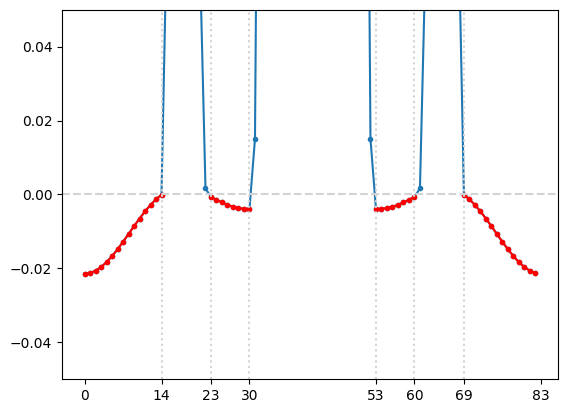

In [216]:
L_S = np.where(As<0,As,np.nan)
plt.plot(As,'.-')
plt.plot(L_S,'.-',color='red')
plt.ylim(-0.05,0.05)
plt.axhline(0,ls='--',color='lightgray')
plt.axvline(14,ls=':',color='lightgray')
plt.axvline(23,ls=':',color='lightgray')
plt.axvline(30,ls=':',color='lightgray')
plt.axvline(83-14,ls=':',color='lightgray')
plt.axvline(83-23,ls=':',color='lightgray')
plt.axvline(83-30,ls=':',color='lightgray')

plt.xticks([0,14,23,30,83-14,83-23,83-30,n])
# plt.plot(x2,As2,'+-')
# plt.plot(As2,'+-')
# plt.plot(As2,'+-')
# plt.ylim(-0.2,0)

In [51]:
np.max(get_lambda(0))

0j

In [49]:
np.sum(Jss(3,r=1)*get_E(1))

(-0.0027904162114914532-1.3183898417423734e-16j)

In [8]:
n = 83
-1 % n 

82